In [2]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 1.7 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=b4b7303906fd0dfe3e94d3a7ce046c528a9052e7ae58884703e9d3c540248156
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import glob
import cv2
import torch
import geffnet
import pretrainedmodels
import os
import time
import random
import argparse
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset, RandomSampler
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import matplotlib.pyplot as plt
from torch.cuda import amp


SEED = 13
PATH_MODEL = './'
PATH_DATA = '../input/make-img-sr48power2mel260-reinforest/train_img.zip'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

'train/cb5ddad47.17.964',

In [5]:
df = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')

df['dif_f'] = df.f_max - df.f_min
df['dif_f'] = df['dif_f'].astype(int)
df['bins'] = pd.cut(df.dif_f, 15, labels=False)
df

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,dif_f,bins
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,3000,3
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,4048,5
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,2718,3
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,3100,3
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,9905,14
...,...,...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75,750,0
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25,1500,1
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00,2343,2
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20,5624,7


In [6]:
rec = []
tr_idx = []
vl_idx = []
data = np.load(PATH_DATA)   

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
for f, (tr, vl) in enumerate(skf.split(data.files[1:], df.bins.values)):
    print(len(tr), len(vl))
    tr_idx.append(tr)
    vl_idx.append(vl) 
    
a = np.take(data.files[1:], tr_idx[0])

972 244
973 243
973 243
973 243
973 243


In [7]:
def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V    
    
class RFDataset(Dataset):

    def __init__(self, data, size, transform = False):        
        self.size = size     
        self.transform = transform
        self.zipdata = np.load(PATH_DATA)
        self.data = data # list name npy,
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        name = self.data[index]      
     
        img = self.zipdata[name]  
        sci_id = name.split('.')[1]
        target = np.zeros(24)
        target[int(sci_id)] = 1
        if self.transform is not None:
            pass
        img = mono_to_color(img)       
        if self.size is not None:
            img = cv2.resize(img, (224, self.size)) 
            
        img = img / 255.0
        img = img.transpose(2, 0, 1).astype(np.float32)        
             
        return torch.tensor(img).float(),torch.tensor(target.astype(np.float16)).float() #check

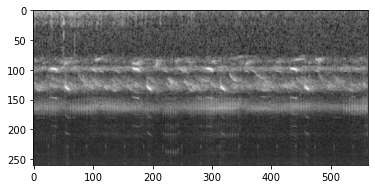

In [8]:
d = RFDataset(a, size = None)
img, target = d[5]
img.shape, target
plt.imshow(np.transpose(img, (1,2,0)))

In [9]:
class Res50(nn.Module):
    
    def __init__(self):
        super(Res50, self).__init__()        
        self.model = pretrainedmodels.__dict__['resnet50'](pretrained = 'imagenet')
        # list(resnet50.children())[:-2]
        self.model.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        in_ch = self.model.last_linear.out_features  
#         self.myfc = nn.Linear(in_ch, 24)
#         in_ch = list(self.model.children())[-3][-1].bn3.num_features
        
        self.myfc = nn.Sequential(nn.Linear(in_ch, 1024),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(1024, 1024),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(1024, 24)
                                 )       
        
        self.model.fc = nn.Identity()   
       
    def extract(self, x):        
        x = self.model(x)        
        return x
        
    def forward(self, x):
        # for test add dim becous 20 bin
        if len(torch.squeeze(x).shape) == 4:
            x = torch.squeeze(x)
        else:
            x
        bs, _, _, _ = x.shape 
        x = self.extract(x) 
        x = x.view(bs, -1)   
        x = self.myfc(x)
        return x
    

class EffB3(nn.Module):
    
    def __init__(self):
        super(EffB3, self).__init__()
        self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
        in_ch = self.model.classifier.in_features #1536
        self.myfc = nn.Sequential(nn.Linear(in_ch, 24))
        self.model.classifier = nn.Identity()   
        
    def extract(self, x):  
        x = self.model(x)
        return x
      
    def forward(self, x):    
        if len(torch.squeeze(x).shape) == 4:
            x = torch.squeeze(x)
        else:
            x
        bs, _, _, _ = x.shape    
        x = self.extract(x)     
        # x = x.view(bs, -1)   
        x = self.myfc(x)
        return x 
    
# add layers

class EffB3(nn.Module):

  def __init__(self):
    super(EffB3, self).__init__()
    self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
    self.model.global_pool = nn.AdaptiveAvgPool2d((1,1)) 
#     self.model.global_pool  = nn.AdaptiveMaxPool2d((1,1))
    in_ch = self.model.classifier.in_features #1536
    self.myfc = nn.Sequential(
        nn.Dropout(0.17418),
        nn.Linear(in_ch, 785),
        nn.BatchNorm1d(785),
#         nn.ReLU(),
        Swish_module(),
        nn.Dropout(0.12), 
        
        nn.Linear(785, 1038),
        nn.BatchNorm1d(1038),
#         nn.ReLU(),
        Swish_module(),
        nn.Dropout(0.3763722),       
        nn.Linear(1038, 24)
    )   
    
    self.model.classifier = nn.Identity()   
      
  def extract(self, x):        
    x = self.model(x)        
    return x
      
  def forward(self, x):    
    if len(torch.squeeze(x).shape) == 4:
        x = torch.squeeze(x)
    else:
        x
    bs, _, _, _ = x.shape    
    x = self.extract(x)     
    # x = x.view(bs, -1)   
    x = self.myfc(x)
    return x

In [13]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def  train(model, loader, loss_f, optimizer, scaler):
    model.train()
    bar = tqdm(loader)
    train_loss = []
    train_target = []
    train_prob = []
    for (img, target) in bar:
        optimizer.zero_grad()
        img, target = img.to(device), target.to(device)
        y_ = model(img)
        pred = loss_f(y_, target)
        pred.backward()
        optimizer.step()
        
        train_loss.append(pred.detach().cpu().numpy())
        prob = nn.Sigmoid()(y_)        
        train_prob.append(prob.detach().cpu())
        train_target.append(target.detach().cpu())            
    
    probs =  torch.cat(train_prob).numpy()
    target = torch.cat(train_target).numpy()   
#     auc = roc_auc_score(target, probs)
    auc =0
    return train_loss, auc


def val_train(model, loader, loss_f):
    val_loss = []
    target_temp = []
    probs = []
 
    val_corr = []
    model.eval()
    with torch.no_grad():
        bar = tqdm(loader)
        for (img, target) in bar:
            img, target = img.to(device), target.to(device)
            y_ = model(img)             
            pred = loss_f(y_, target)            
            prob = nn.Sigmoid()(y_)             
            _, tar_idx = torch.max(target, dim= 1)
            _, ans_idx = torch.max(y_, dim= 1) #dim=0 values, if dim =1 return max value and index max value
            corrects = 0
            for i in range(0, len(ans_idx)):
                if ans_idx[i] == tar_idx[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)

            val_loss.append(pred.detach().cpu())        
            probs.append(prob.detach().cpu())

            target_temp.append(target.detach().cpu())   
            
    val_loss = np.mean(val_loss) 
    val_corr = np.sum(val_corr)
    probs =  torch.cat(probs).numpy()   
    target = torch.cat(target_temp).numpy()  
    

    pr = average_precision_score(target, probs, average='weighted')
    pr_m = average_precision_score(target, probs, average='micro')
    

    lraps = label_ranking_average_precision_score(target, probs)
    score_loss = 0
    
    print(f'Correct ---------{np.sum(val_corr)}/{len(target)}')
    
    auc = roc_auc_score(target, probs)
    correct = np.sum(val_corr)

    return val_loss, auc, lraps, score_loss, pr,pr_m, correct


def showtime(model, f: int, data, tr_idx: np.array, vl_idx: np.array, scaler):
    start = time.ctime().replace('  ', ' ').replace(' ', '_')    
    print('Fold: ', f)

    tr = np.take(data.files[1:], tr_idx[f])
    vl = np.take(data.files[1:], vl_idx[f])
    print(tr.shape, vl.shape)
    
    tr_dataset = RFDataset(tr, size = None)
    vl_dataset = RFDataset(vl, size = None)
    
    tr_loader = DataLoader(tr_dataset, batch_size=14, num_workers=1,
                           sampler=RandomSampler(tr_dataset))
    vl_loader = DataLoader(vl_dataset, batch_size=14, num_workers=1)    

    kernel_type = type(model).__name__
    model = model.to(device)
    # need addd pos_weight 
    pos_weights = torch.ones(24)
    pos_weights = pos_weights * 24    
    loss_f = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weights).to(device)       
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='min',
                                                     factor=0.9,
                                                     patience=3, 
                                                     verbose=True)

    auc_max = 0
    correct_max = 0
    for ep in range(30):
        print('Epoch: ', ep + 1)
        
        train_loss, auc_train = train(model, tr_loader, loss_f, optimizer, scaler)
        val_loss, auc, lraps, score_loss, pr,pr_m, correct = val_train(model, vl_loader, loss_f)
        log = time.ctime().replace('  ', ' ').replace(' ', '_') + ',' + f'Fold:{f},Epoch:{ep},lr:{optimizer.param_groups[0]["lr"]:.7f},Auc_val:{auc:.5f},Auc_train:{auc_train:.5f},LRAPS:{lraps:.5f},lwlrap:{score_loss:.5f},train_loss:{np.mean(train_loss):.5f},val_loss:{val_loss:.5f}'
               
        print(log)
        if auc > auc_max:
            print(f'auc_max: {auc} --> {auc_max}, PRw: {pr}, PRmicro: {pr_m}). Saving model ...')
            torch.save(model.state_dict(), os.path.join(PATH_MODEL, f'{kernel_type}_best_fold_{f}.pth'))
            auc_max = auc
        scheduler.step(val_loss) 
#         scheduler.step()
    torch.cuda.empty_cache()   

In [ ]:
set_seed(SEED)
scaler = amp.GradScaler()  
for i in range(5):
    model = EffB3()
    showtime(model, i, data, tr_idx, vl_idx, scaler)